### Atenção:
Utilize Java JDK 1.8 ou 11 e Apache Spark 2.4.2

**Caso receba mensagem de erro "name 'sc' is not defined", interrompa o pyspark e apague o diretório metastore_db no mesmo diretório onde está este Jupyter notebook**

## <font color='blue'>Spark MLLib - Clustering - K-Means</font>

<strong> Descrição </strong>
<ul style="list-style-type:square">
  <li>Algoritmo Não Supervisionado.</li>
  <li>Agrupamento de Dados por Similaridade.</li>
  <li>Particiona os dados em um número "k" de clusters, sendo que cada observação pertende a apenas um cluster.</li>
  <li>A clusterização é feita medindo a distância entre os pontos de dados e agrupando-os.</li>
  <li>Múltiplas medidas de distância podem ser usadas, como distância Euclidiana e distância Manhattan.</li>
</ul>

<dl>
  <dt>Vantagens</dt>
  <dd>- Veloz</dd>
  <dd>- Eficiente quando se tem muitas variáveis</dd>
  <br />
  <dt>Desvantagens</dt>
  <dd>- O valor de K precisa ser conhecido</dd>
  <dd>- O valor inicial de k tem influência nos clusters criados</dd>
  <br />
  <dt>Aplicação</dt>
  <dd>- Agrupamento preliminar antes de se aplicar técnicas de classificação</dd>
  <dd>- Clusterização geográfica</dd>
</dl>

## Agrupando automóveis

In [2]:
# Imports
import math
import pandas as pd
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
import matplotlib.pylab as plt
%matplotlib inline

/opt/homebrew/anaconda3/envs/python10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Spark Session - usada quando se trabalha com Dataframes no Spark
spSession = SparkSession.builder.master("local").appName("Kayo-SparkMLLib").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/15 00:01:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/15 00:01:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/15 00:01:45 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [5]:
sc = spSession.sparkContext

In [6]:
# Carregando os dados e gerando um RDD
carrosRDD = sc.textFile("data/carros2.csv")
carrosRDD.cache()

data/carros2.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [7]:
# Removendo a primeira linha do arquivo (cabeçalho)
primeiraLinha = carrosRDD.first()
carrosRDD2 = carrosRDD.filter(lambda x: x != primeiraLinha)
carrosRDD2.count()

197

In [8]:
carrosRDD2.take(5)

['subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118',
 'chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151',
 'mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195',
 'toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348',
 'mitsubishi,gas,std,two,hatchback,fwd,four,68,5500,37,41,5389']

In [9]:
# Convertendo e limpando os dados
def transformToNumeric( inputStr) :
    attList = inputStr.split(",")

    doors = 1.0 if attList[3] == "two" else 2.0
    body = 1.0 if attList[4] == "sedan" else 2.0 
       
    linhas = Row(DOORS = doors, BODY = float(body), HP = float(attList[7]), RPM = float(attList[8]),
                 MPG = float(attList[9]))
    return linhas

In [10]:
# Aplicando a função
carrosRDD3 = carrosRDD2.map(transformToNumeric)
carrosRDD3.persist()
carrosRDD3.take(5)

[Row(DOORS=1.0, BODY=2.0, HP=69.0, RPM=4900.0, MPG=31.0),
 Row(DOORS=1.0, BODY=2.0, HP=48.0, RPM=5100.0, MPG=47.0),
 Row(DOORS=1.0, BODY=2.0, HP=68.0, RPM=5000.0, MPG=30.0),
 Row(DOORS=1.0, BODY=2.0, HP=62.0, RPM=4800.0, MPG=35.0),
 Row(DOORS=1.0, BODY=2.0, HP=68.0, RPM=5500.0, MPG=37.0)]

In [11]:
# Criando um Dataframe
carrosDF = spSession.createDataFrame(carrosRDD3)
carrosDF.show()

+-----+----+----+------+----+
|DOORS|BODY|  HP|   RPM| MPG|
+-----+----+----+------+----+
|  1.0| 2.0|69.0|4900.0|31.0|
|  1.0| 2.0|48.0|5100.0|47.0|
|  1.0| 2.0|68.0|5000.0|30.0|
|  1.0| 2.0|62.0|4800.0|35.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|60.0|5500.0|38.0|
|  1.0| 1.0|69.0|5200.0|31.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|68.0|5000.0|31.0|
|  1.0| 2.0|68.0|5500.0|31.0|
|  2.0| 2.0|68.0|5500.0|31.0|
|  2.0| 2.0|68.0|5500.0|31.0|
|  1.0| 2.0|70.0|5400.0|38.0|
|  1.0| 2.0|62.0|4800.0|31.0|
|  1.0| 2.0|68.0|5500.0|31.0|
|  1.0| 2.0|58.0|4800.0|49.0|
|  2.0| 2.0|62.0|4800.0|31.0|
|  1.0| 2.0|76.0|6000.0|30.0|
|  2.0| 1.0|70.0|5400.0|38.0|
+-----+----+----+------+----+
only showing top 20 rows



In [12]:
# Sumarizando os dados e extraindo a média e o desvio padrão
estats = carrosDF.describe().toPandas()
medias = estats.iloc[1,1:5].values.tolist()
desvios = estats.iloc[2,1:5].values.tolist()

In [16]:
estats

,summary,DOORS,BODY,HP,RPM,MPG
0,count,197,197,197,197,197
1,mean,1.5685279187817258,1.532994923857868,103.60406091370558,5118.0203045685275,25.15228426395939
2,stddev,0.49654352778167493,0.5001812579359883,37.63920534951834,481.03591405011434,6.437862917085909
3,min,1.0,1.0,48.0,4150.0,13.0
4,max,2.0,2.0,262.0,6600.0,49.0


In [17]:
medias

['1.5685279187817258',
 '1.532994923857868',
 '103.60406091370558',
 '5118.0203045685275']

In [18]:
desvios

['0.49654352778167493',
 '0.5001812579359883',
 '37.63920534951834',
 '481.03591405011434']

In [20]:
# Colocando a média e o desvio padrão e variáves do tipo Broadcast
bc_media = sc.broadcast(medias)
bc_desvio = sc.broadcast(desvios)

In [22]:
# Função para centralizar e aplicar escala aos dados. Cada valor será subtraído da média então dividido pelo desvio padrão
def centerAndScale(inRow) :
    global bc_media
    global bc_desvio
    
    meanArray = bc_media.value
    stdArray = bc_desvio.value

    retArray = []
    
    for i in range(len(meanArray)):
        retArray.append( (float(inRow[i]) - float(meanArray[i])) / float(stdArray[i]) )
    return Vectors.dense(retArray)

In [23]:
carrosRDD4 = carrosDF.rdd.map(centerAndScale)
carrosRDD4.collect()

[DenseVector([-1.145, 0.9337, -0.9194, -0.4532]),
 DenseVector([-1.145, 0.9337, -1.4773, -0.0375]),
 DenseVector([-1.145, 0.9337, -0.9459, -0.2453]),
 DenseVector([-1.145, 0.9337, -1.1053, -0.6611]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941]),
 DenseVector([-1.145, 0.9337, -1.1585, 0.7941]),
 DenseVector([-1.145, -1.0656, -0.9194, 0.1704]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941]),
 DenseVector([-1.145, 0.9337, -0.9459, -0.2453]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941]),
 DenseVector([0.869, 0.9337, -0.9459, 0.7941]),
 DenseVector([0.869, 0.9337, -0.9459, 0.7941]),
 DenseVector([-1.145, 0.9337, -0.8928, 0.5862]),
 DenseVector([-1.145, 0.9337, -1.1053, -0.6611]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941]),
 DenseVector([-1.145, 0.9337, -1.2116, -0.6611]),
 DenseVector([0.869, 0.9337, -1.1053, -0.6611]),
 DenseVector([-1.145, 0.9337, -0.7334, 1.8335]),
 DenseVector([0.869, -1.0656, -0.8928, 0.5862]),
 DenseVector([

In [24]:
# Criando um Dataframe
carrosRDD5 = carrosRDD4.map(lambda f:Row(features = f))
carrosDF = spSession.createDataFrame(carrosRDD5)
carrosDF.select("features").show(10)

+--------------------+
|            features|
+--------------------+
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
+--------------------+
only showing top 10 rows



In [25]:
# Criando o modelo
kmeans = KMeans(k = 3, seed = 1)
modelo = kmeans.fit(carrosDF)

In [26]:
# Previsões
previsoes = modelo.transform(carrosDF)
previsoes.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[0.86895117361793...|         0|
|[0.86895117361793...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[0.86895117361793...|         0|
|[-1.1449709581789...|         0|
|[0.86895117361793...|         1|
+--------------------+----------+
only showing top 20 rows



In [27]:
def unstripData(instr) :
    return (instr["prediction"], instr["features"][0], instr["features"][1], instr["features"][2], instr["features"][3])

In [28]:
carrosRDD6 = previsoes.rdd.map(unstripData)
predList = carrosRDD6.collect()
predPd = pd.DataFrame(predList)

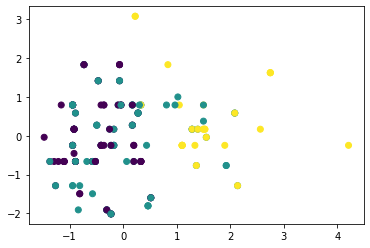

In [29]:
# Gráfico com o resultados dos clusters criados
plt.cla()
plt.scatter(predPd[3], predPd[4], c = predPd[0])